In [1]:
# !pip3 install matplotlib pandas seaborn
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from databuddy import get_data, get_votes

In [20]:
data = get_data()
votes = get_votes()

data = data[data.state.isin(votes.index)]

data["state_popn"] = data.state.map(lambda s: votes.loc[s].Pop)
data["test_pos_state_popn"] = 100*data.tot_cases / data.state_popn
data["new_case_state_popn"] = 100*data.new_case / data.state_popn
data["death_pct_state_popn"] = 100*data.tot_death / data.state_popn

In [21]:
data["political_affiliation"] = data.state.map(lambda s: "D" if votes.loc[s].votesRep < votes.loc[s].votesDem else "R")

In [98]:
# STATES = ["MD", "PA", "AL", "TX", "ND", "NY"]
STATE_COLORS = {
    # Nice hex colors spanning the spectrum
    "MD": "#8c564b",
    "PA": "#e377c2",
    "AL": "#7f7f7f",
    "TX": "#bcbd22",
    "ND": "#17becf",
    "NY": "#1f77b4",
}
 

In [23]:
len(data)

39786

In [24]:
data.reset_index(inplace=True)

In [25]:
data = data[~pd.isna(data.tot_cases) & data.tot_cases > 0]

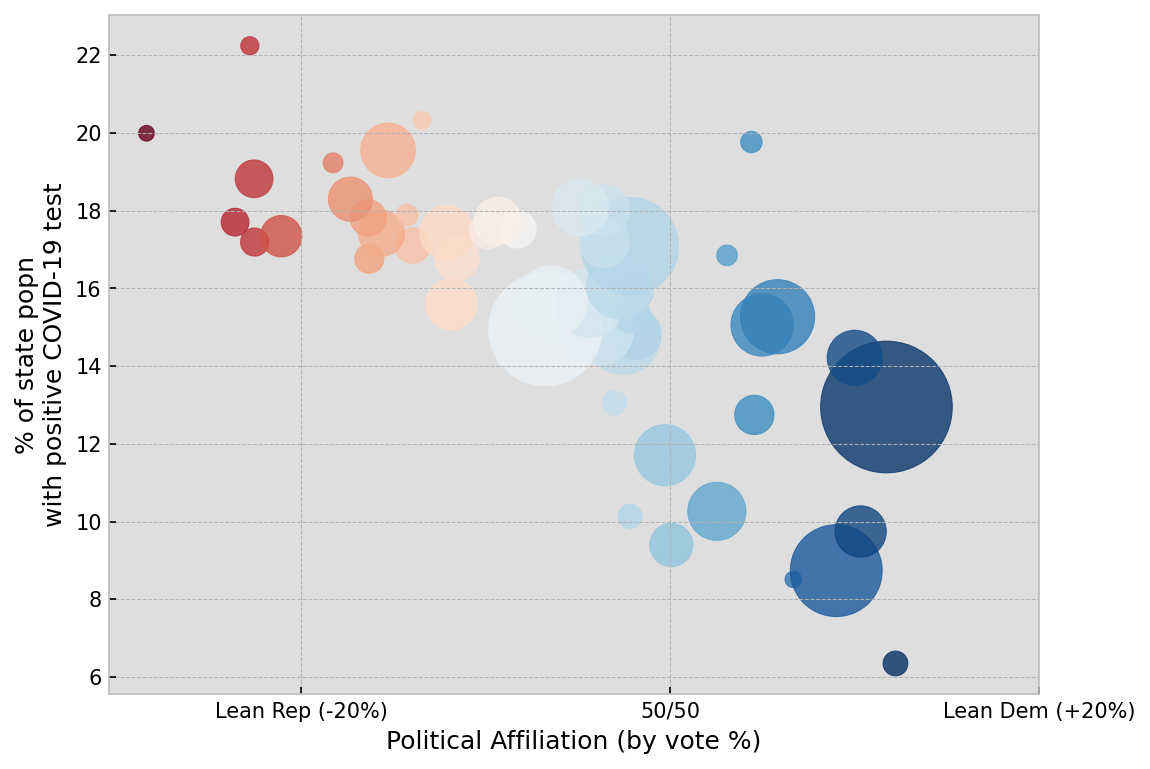

In [26]:
with plt.style.context("bmh"):
    plt.figure(figsize=(8, 6), dpi=150,)
    plt.gca().set_facecolor("#dedede")
    plt.scatter(
        data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes.loc[x].percD),
        data.groupby("state").test_pos_state_popn.max().sort_values(),
        c=data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes.loc[x].percD),
        cmap='RdBu', marker='o', s=[
            data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes.loc[x].Pop)/10000
        ], alpha=0.8
    )
    plt.xlabel("Political Affiliation (by vote %)")
    plt.ylabel("% of state popn\nwith positive COVID-19 test")
    plt.xticks([30, 50, 70], ["Lean Rep (-20%)", "50/50", "Lean Dem (+20%)"])

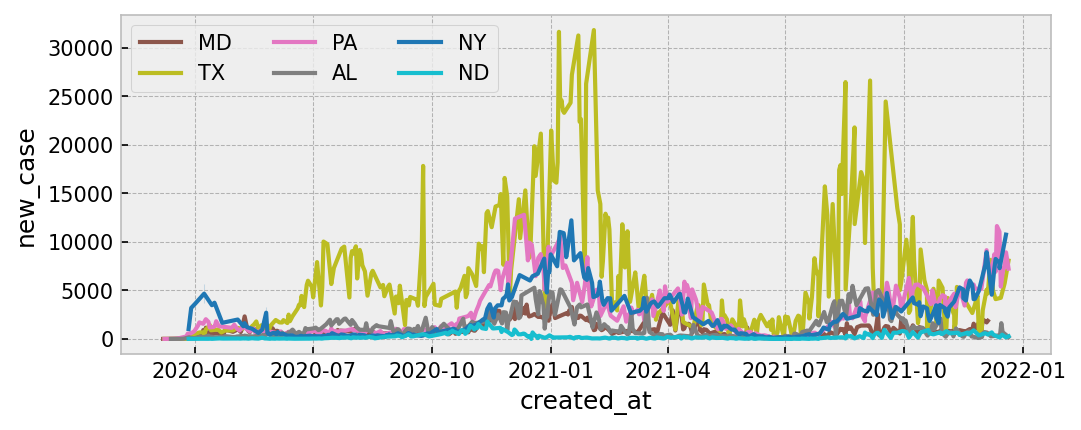

In [102]:
_plotting_data = data[data.state.isin(STATE_COLORS)]
_plotting_data = _plotting_data[_plotting_data.new_case > 0.001]

_plotting_labels = _plotting_data.groupby("state").new_case.max()

with plt.style.context("bmh"):
    plt.figure(figsize=(8, 3), dpi=150)

    sns.lineplot(
        y='new_case',
        x='created_at',
        data=_plotting_data,
        hue="state",
        palette=STATE_COLORS,
    )
#     plt.yscale("log")
    leg = plt.legend(ncol=3)

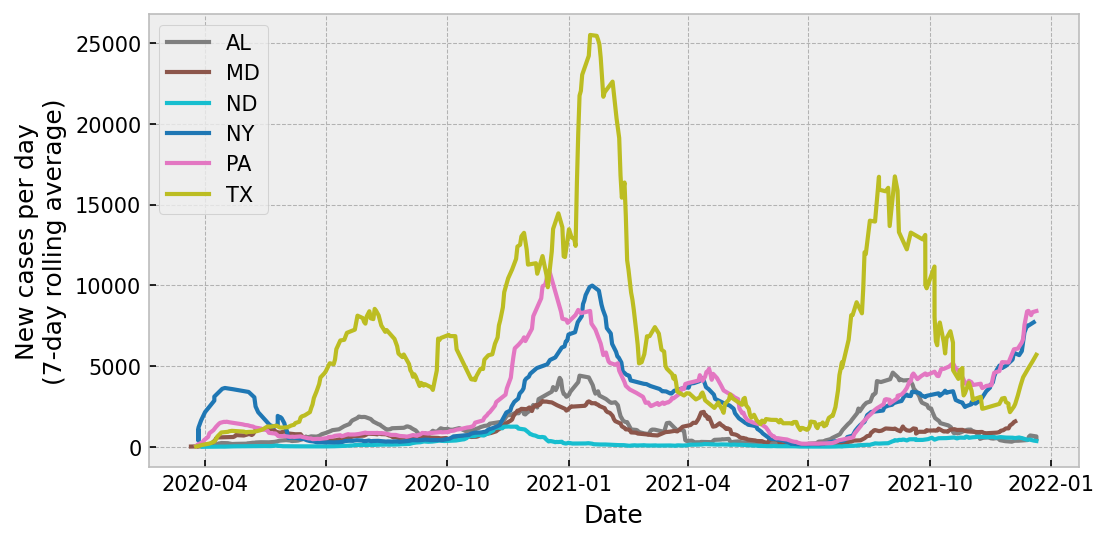

In [100]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    groups = _plotting_data.groupby('state')
    for k in sorted(STATES):
        v = groups.get_group(k)
        # X is date
        # Y is rolling average of new cases over last 7 days
        X = v.created_at.values
        Y = v.new_case.rolling(7).mean().values
        ax.plot(X, Y, label=k, color=STATE_COLORS[k])

    plt.ylabel("New cases per day\n(7-day rolling average)")
    plt.xlabel("Date")
    plt.legend(loc='upper left')


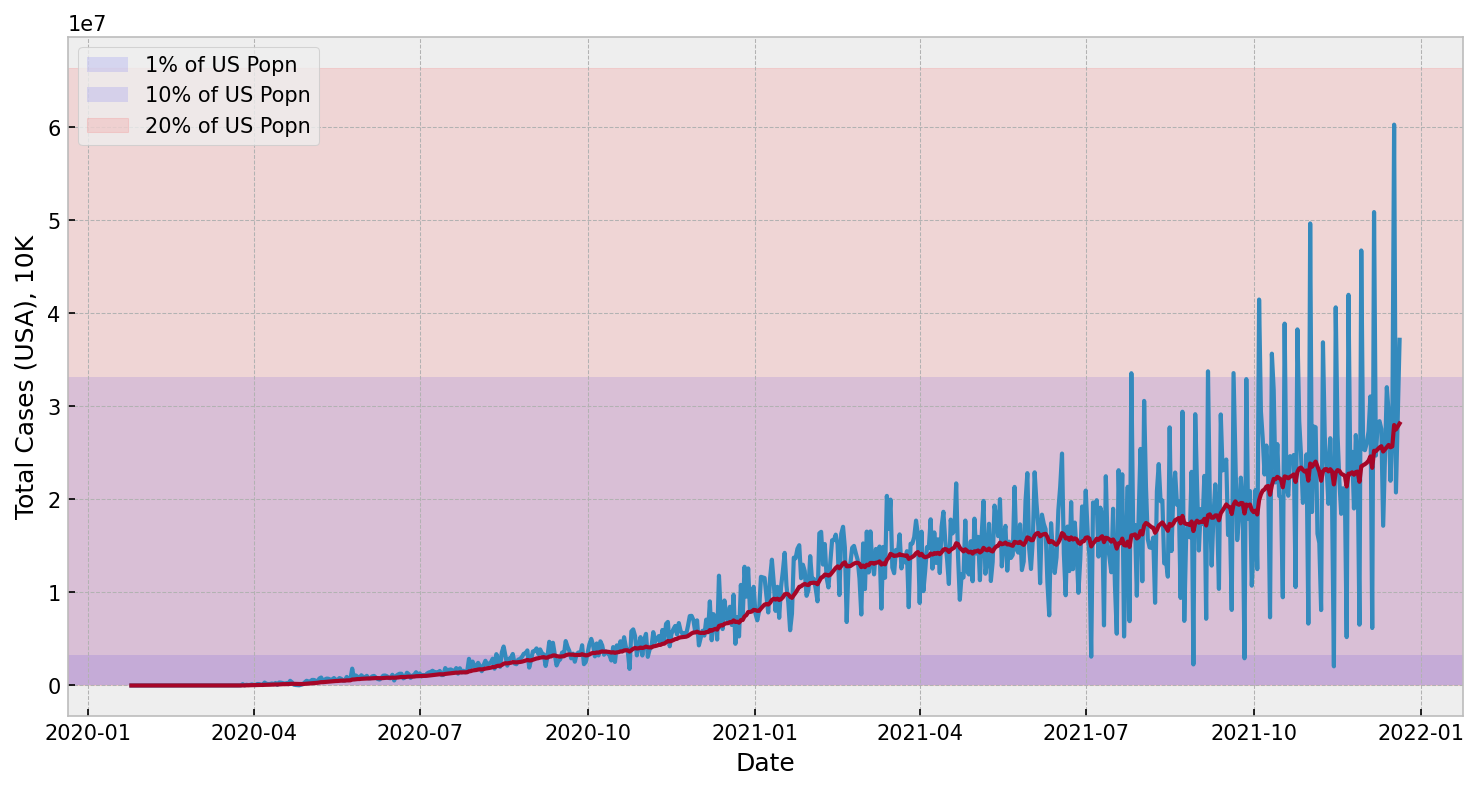

In [101]:
_d = data.groupby(data.created_at.dt.date).sum()

POPN_ESTIMATE = 332_000_000

with plt.style.context("bmh"):
    plt.figure(figsize=(12, 6), dpi=150)
    sns.lineplot(x='created_at', y=_d.tot_cases, data=_d, )
    sns.lineplot(x='created_at', y=_d.tot_cases.ewm(14).mean(), data=_d)
    plt.xlabel("Date")
    plt.ylabel("Total Cases (USA), 10K")
    
    plt.axhspan(0, POPN_ESTIMATE*0.01, alpha=0.1, label="1% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.1, alpha=0.1, label="10% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.2, alpha=0.1, color='r', label="20% of US Popn")
    plt.legend()
#     plt.yscale("log")